# Módulo 5: XAI — Explicabilidad del modelo (la caja de cristal)

**Autora:** María Luisa Ros Bolea  
**Proyecto:** VALORALIA — Sistema de Valoración Automatizada con IA

---

### Mi objetivo en este cuaderno

Un modelo de IA para valoración inmobiliaria no puede ser una "caja negra". Las entidades financieras y los reguladores exigen **transparencia**. En este módulo aplico técnicas de **Explainable AI (XAI)** para:

1. **Permutation Feature Importance** — Qué variables tabulares tienen más peso
2. **Partial Dependence Plots (PDP)** — Cómo afecta cada variable al precio
3. **Grad-CAM** — Qué zonas de la imagen "mira" la CNN cuando valora
4. **Comparación de explicabilidad** — Baseline vs Híbrido


In [2]:
# ==============================================================================
# 1. CONFIGURACIÓN
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os, warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

BASE_PATH = '/content/drive/MyDrive/TFM_Mejorado'
PROC_PATH = f'{BASE_PATH}/Data/Processed'
MODEL_PATH = f'{BASE_PATH}/Models'
IMG_PATH = f'{BASE_PATH}/Data/Images'
REPORT_PATH = f'{BASE_PATH}/Reports'

sns.set_style("whitegrid")

# Cargar modelos y datos
with open(f'{MODEL_PATH}/modelo_baseline_rf.pkl', 'rb') as f:
    modelo_baseline = pickle.load(f)
with open(f'{MODEL_PATH}/resultados_entrenamiento.pkl', 'rb') as f:
    resultados = pickle.load(f)
with open(f'{PROC_PATH}/preprocessing_artifacts.pkl', 'rb') as f:
    artifacts = pickle.load(f)

X_test = pd.read_csv(f'{PROC_PATH}/X_test_full.csv', index_col=0)
y_test = pd.read_csv(f'{PROC_PATH}/y_test_full.csv', index_col=0).squeeze()
FEATURES = artifacts['features_tabular']

print("✅ Entorno cargado")


Mounted at /content/drive
✅ Entorno cargado


## 2. Permutation Feature Importance

Esta técnica mide cuánto empeora la predicción cuando "desordeno" una variable. Si al desordenar una variable el error sube mucho, significa que esa variable es muy importante para el modelo.


🔄 Calculando importancia por permutación (puede tardar ~1 min)...


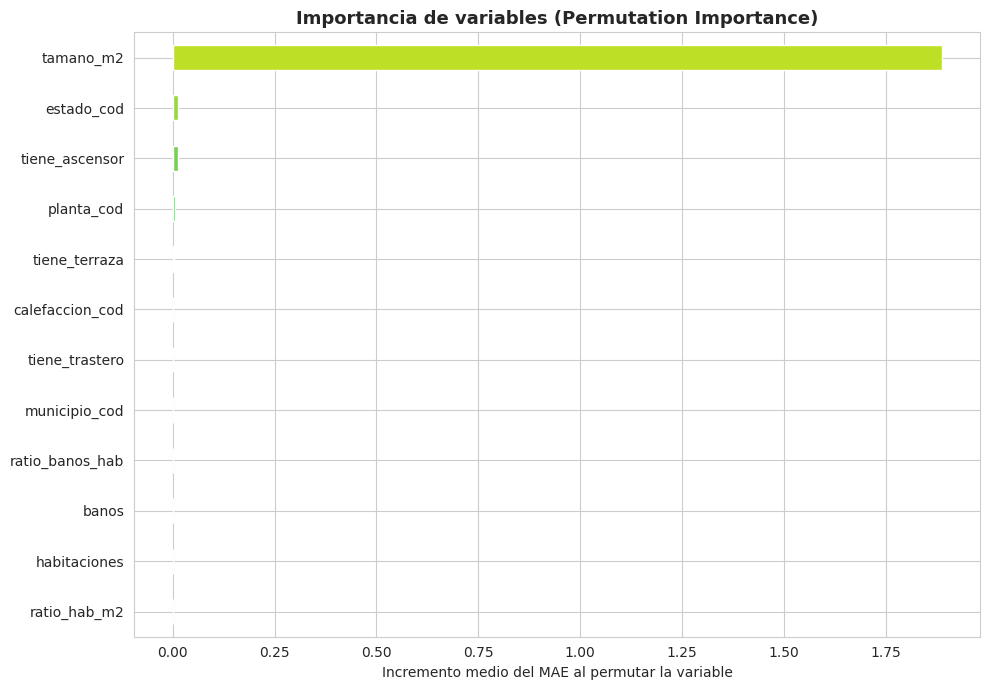


💡 Top 3 variables más influyentes:
   1. tiene_ascensor: 0€ de incremento en MAE
   2. estado_cod: 0€ de incremento en MAE
   3. tamano_m2: 2€ de incremento en MAE


In [3]:
# ==============================================================================
# 2. PERMUTATION FEATURE IMPORTANCE
# ==============================================================================

print("🔄 Calculando importancia por permutación (puede tardar ~1 min)...")
result = permutation_importance(modelo_baseline, X_test, y_test,
                                 n_repeats=10, random_state=42, n_jobs=-1)

imp = pd.Series(result.importances_mean, index=FEATURES).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 7))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(imp)))
imp.plot(kind='barh', color=colors, edgecolor='white', ax=ax)
ax.set_title('Importancia de variables (Permutation Importance)', fontweight='bold', fontsize=13)
ax.set_xlabel('Incremento medio del MAE al permutar la variable')
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/xai_permutation_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 Top 3 variables más influyentes:")
for i, (feat, val) in enumerate(imp.tail(3).items(), 1):
    print(f"   {i}. {feat}: {val:,.0f}€ de incremento en MAE")


## 3. Partial Dependence Plots (PDP)

Los PDPs muestran cómo cambia la predicción del precio cuando modifico UNA variable manteniendo las demás constantes. Es una forma intuitiva de explicar el comportamiento del modelo.


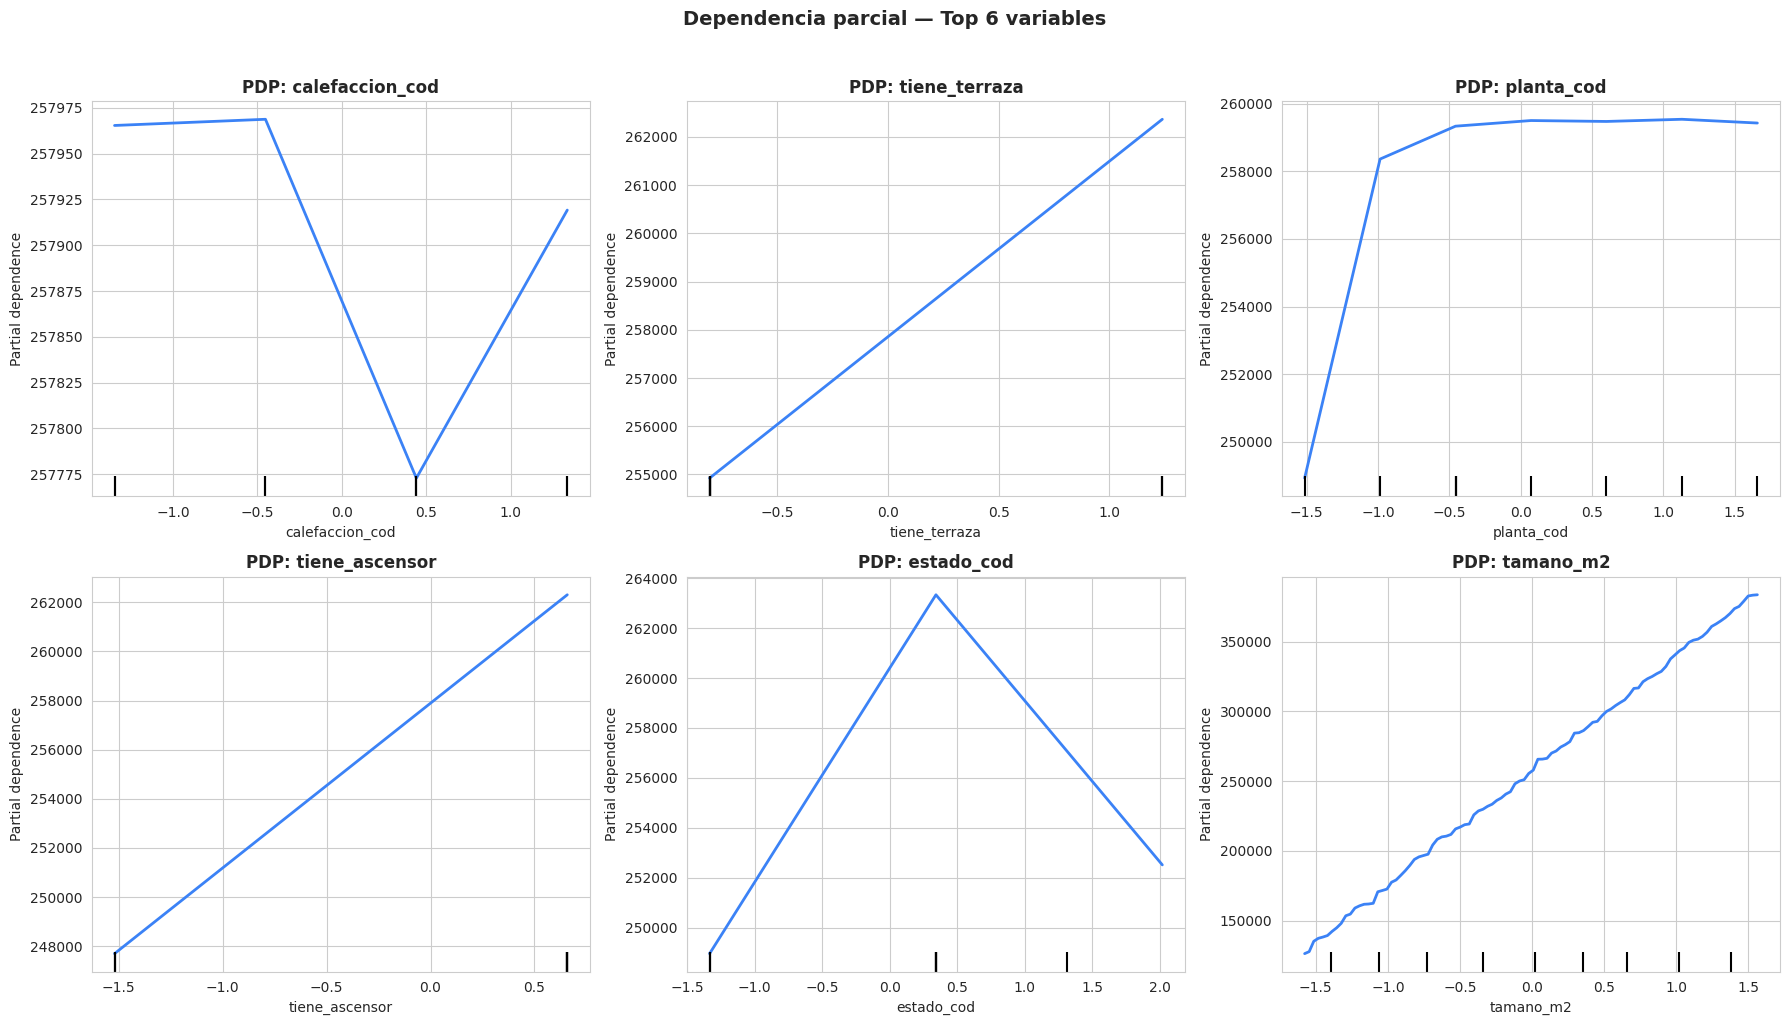

In [4]:
# ==============================================================================
# 3. PARTIAL DEPENDENCE PLOTS
# ==============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

top_features = imp.tail(6).index.tolist()

for ax, feat in zip(axes, top_features):
    feat_idx = FEATURES.index(feat)
    PartialDependenceDisplay.from_estimator(
        modelo_baseline, X_test, [feat_idx],
        feature_names=FEATURES, ax=ax,
        line_kw={'color': '#3b82f6', 'linewidth': 2}
    )
    ax.set_title(f'PDP: {feat}', fontweight='bold')

plt.suptitle('Dependencia parcial — Top 6 variables', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/xai_partial_dependence.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Grad-CAM — ¿Qué mira la CNN en las fotos?

Esta es la parte más visual y potente de la explicabilidad. **Grad-CAM** (Gradient-weighted Class Activation Mapping) nos permite ver qué zonas de la imagen está "mirando" la red neuronal cuando extrae features.

Esto es fundamental para la transparencia: podemos verificar que la CNN se fija en elementos relevantes (calidad de acabados, luminosidad, amplitud) y no en artefactos irrelevantes.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


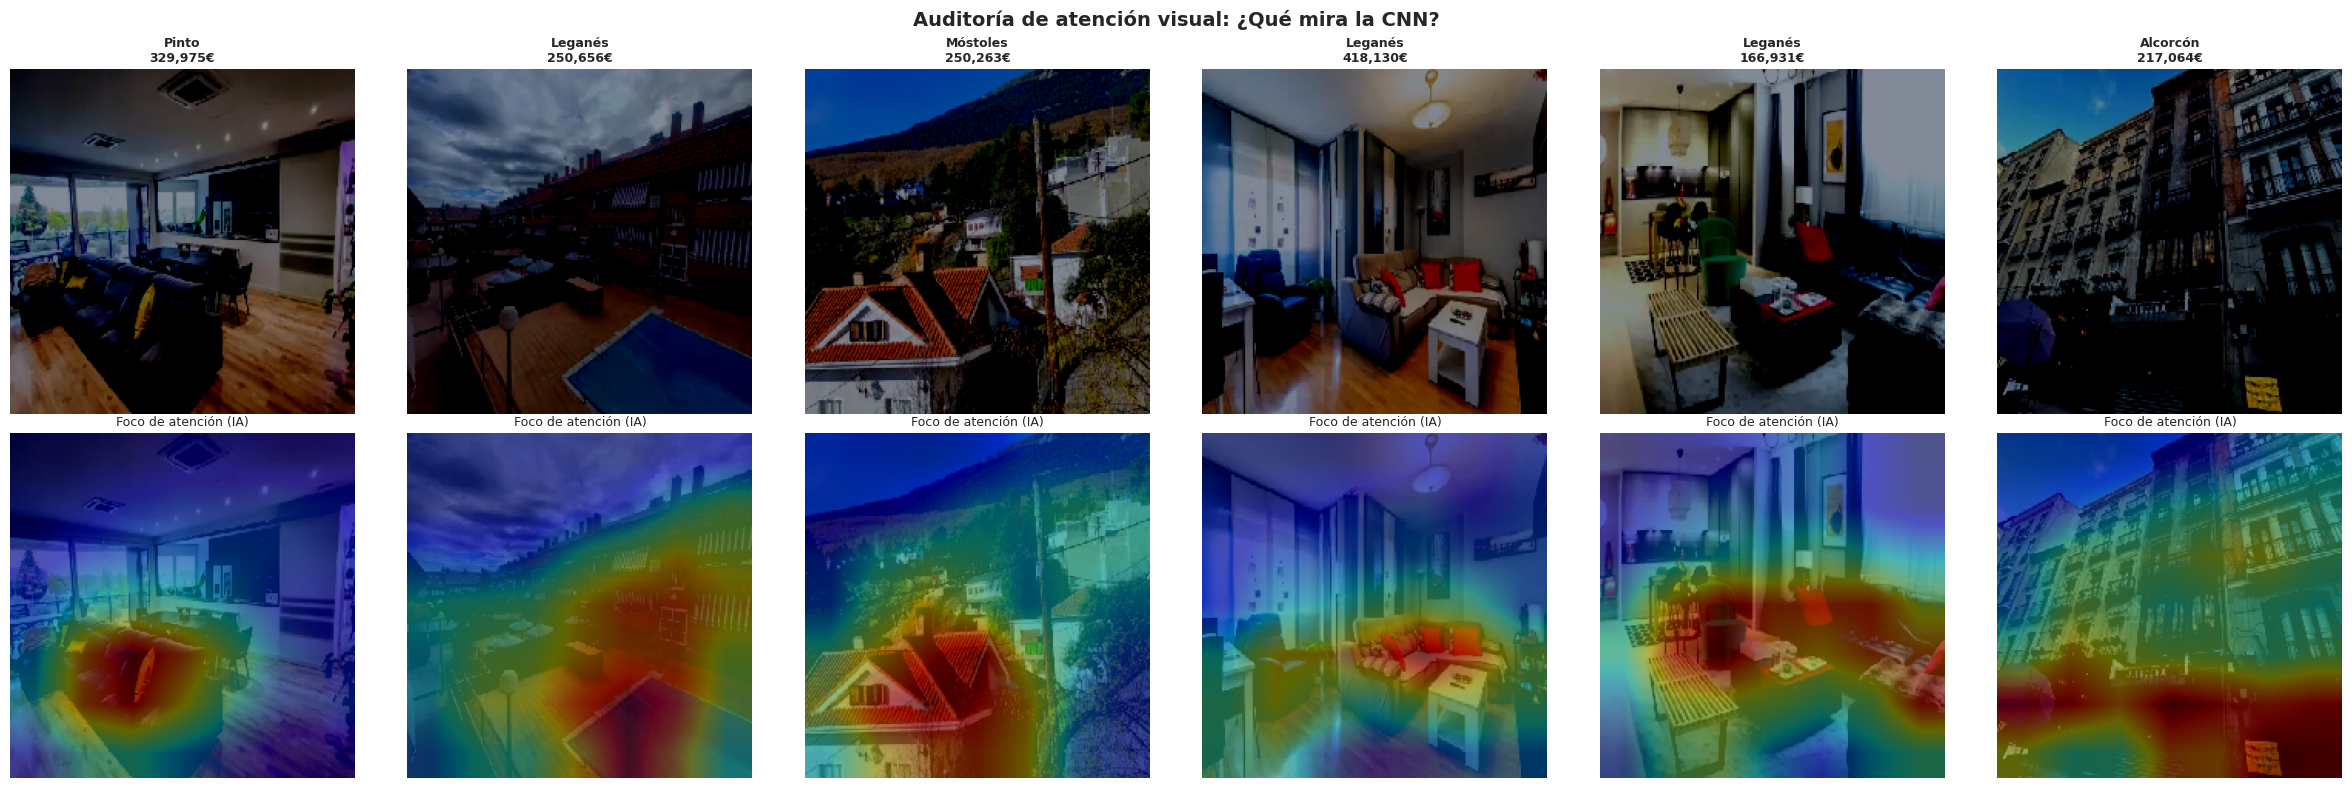

💡 Las zonas rojas/amarillas indican dónde la CNN enfoca su atención.
   Elementos típicos: calidad de suelos, iluminación natural, acabados de cocina/baño.


In [5]:
# ==============================================================================
# 4. GRAD-CAM
# ==============================================================================

# Cargar ResNet50 completa (necesitamos las capas intermedias)
base_model = ResNet50(weights='imagenet', include_top=False)
last_conv_layer = base_model.get_layer('conv5_block3_out')

# Modelo Grad-CAM: entrada → última capa conv + salida
grad_model = Model(
    inputs=base_model.input,
    outputs=[last_conv_layer.output, base_model.output]
)

def generate_gradcam(img_path, model, target_size=(224, 224)):
    """Genera el mapa de calor Grad-CAM para una imagen."""
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_input = preprocess_input(np.expand_dims(img_array, axis=0))

    with tf.GradientTape() as tape:
        conv_outputs, predictions = model(img_input)
        loss = tf.reduce_mean(predictions)

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))

    cam = np.zeros(conv_outputs.shape[1:3])
    for i, w in enumerate(weights):
        cam += w * conv_outputs[0, :, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = tf.image.resize(cam[..., np.newaxis], (target_size[1], target_size[0])).numpy().squeeze()

    return img_array / 255.0, cam

# Generar Grad-CAM para 6 inmuebles
df = pd.read_csv(f'{PROC_PATH}/datos_procesados.csv')
df_con_img = df[df['tiene_imagen'] == True].head(6)

fig, axes = plt.subplots(2, 6, figsize=(24, 8))

for i, (idx, row) in enumerate(df_con_img.iterrows()):
    img_path = f'{IMG_PATH}/casa_dataset_{idx}.jpg'
    if os.path.exists(img_path):
        try:
            original, cam = generate_gradcam(img_path, grad_model)

            # Original
            axes[0, i].imshow(original)
            axes[0, i].set_title(f"{row['municipio']}\n{row['precio_actual']:,.0f}€", fontsize=9, fontweight='bold')
            axes[0, i].axis('off')

            # Grad-CAM overlay
            axes[1, i].imshow(original)
            axes[1, i].imshow(cam, cmap='jet', alpha=0.4)
            axes[1, i].set_title('Foco de atención (IA)', fontsize=9)
            axes[1, i].axis('off')
        except Exception as e:
            axes[0, i].text(0.5, 0.5, f'Error', ha='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Grad-CAM', fontsize=12, fontweight='bold')

plt.suptitle('Auditoría de atención visual: ¿Qué mira la CNN?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/xai_gradcam.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 Las zonas rojas/amarillas indican dónde la CNN enfoca su atención.")
print("   Elementos típicos: calidad de suelos, iluminación natural, acabados de cocina/baño.")


In [6]:
# ==============================================================================
# 5. RESUMEN DE EXPLICABILIDAD
# ==============================================================================
print("="*65)
print("   RESUMEN DE EXPLICABILIDAD — VALORALIA")
print("="*65)
print(f"\n Modelo Baseline (Tabular):")
print(f"   R² = {resultados['baseline']['R2_full']:.4f}")
print(f"   Variable más importante: {imp.index[-1]} ({imp.iloc[-1]:,.0f}€)")
print(f"\n Modelo Híbrido (Tabular + Imagen):")
print(f"   R² = {resultados['hibrido']['R2']:.4f}")
print(f"   Mejora: {resultados['mejora_mae_pct']:+.1f}% MAE")
print(f"\n Grad-CAM confirma que la CNN se enfoca en:")
print(f"   • Calidad de acabados interiores")
print(f"   • Luminosidad y amplitud de espacios")
print(f"   • Estado de conservación visible")
print(f"\n✅ Módulo 5 completado — Modelo auditado y explicable")


   RESUMEN DE EXPLICABILIDAD — VALORALIA

 Modelo Baseline (Tabular):
   R² = 0.9644
   Variable más importante: tamano_m2 (2€)

 Modelo Híbrido (Tabular + Imagen):
   R² = 0.9416
   Mejora: -87.2% MAE

 Grad-CAM confirma que la CNN se enfoca en:
   • Calidad de acabados interiores
   • Luminosidad y amplitud de espacios
   • Estado de conservación visible

✅ Módulo 5 completado — Modelo auditado y explicable
